# Training a custom AR-CNN model 
In this Jupyter notebook, we guide you through several steps of the data science life cycle. We explain how to acquire the data that you use for this project, 
provide some exploratory data analysis (**EDA**), and show how we augment the data during training. 

We also walk through the project's model architecture. Finally, we explain how to use the trained model to perform inference, the results of which you can submit to the *Spin the model* Chartbusters challenge.

## Getting started
Music generation using machine learning (ML) has been an active area of research for the ML community.

### Prerequisites
If you aren’t familiar with generative AI or the autoregressive convolutional neural network (AR-CNN) model, we recommend reading the following before using this notebook: 

1. [Learn the basics of generative AI](https://d32g4xocucupjo.cloudfront.net/#welcome)
2. [Introduction to autoregressive convolutional neural networks](https://console.aws.amazon.com/deepcomposer/home?region=us-east-1#learningCapsules/autoregressive)
3. [A deep dive into training an AR-CNN model](https://console.aws.amazon.com/deepcomposer/home?region=us-east-1#learningCapsules/deeperDiveIntoARCNN)



## Using generative AI to create music 
There have been two primary approaches to generating music using ML techniques. In the first approach, the problem of music generation is treated as an image generation problem. In the second approach, music generation is treated like a time-series problem. To solve these kinds of problems, musicians and data scientists have traditionally used convolutional neural network (CNN) modeling techniques. For example: 

- The [Google Bach Doodle](https://www.google.com/doodles/celebrating-johann-sebastian-bach) used an algorithm called [CocoNET](https://magenta.tensorflow.org/coconet) to generate music using generative AI.

- The [MuseGAN](https://openai.com/blog/musegan/) model is based on a generative adversarial network (GAN) approach.

### Using autoregressive approaches for image generation
In a traditional autoregressive approach, you condition an upcoming value on the values that came before it. This kind of approach helps create realistic images. For example:

- The **PixelCNN** is a type of autoregressive generative model. It predicts an image pixel based off of all previously generated image pixels.

- The **Orderless NADE** approach is similar to the PixelCNN approach except that generation of the pixels is *ordering invariant*, meaning that the generation of the next pixel doesn't necessarily have to be linear.

### The AWS DeepComposer approach to generating music  
Autoregressive-based approaches are prone to accumulate errors during training. To help mitigate this problem, we train our AR-CNN model so that it can detect and then fix mistakes, including those made by the model itself.

We do this by treating music generation as a series of *edit events*, which can be either the addition or removal of a note. An *edit sequence* is a series of edit events. Every edit sequence can directly correspond to a piano roll.

By training our model to view the problem as edit events rather than as an entire image or just the addition of notes, we found that it can offset the accumulation of errors and generate higher quality music.

Now that you understand the basic theory behind our approach, let’s dive into the code. In the next section, we show examples of the piano roll format that we use for training the model.

## Installing dependencies
First, let's install and import all of the Python packages that we will use in this tutorial.

In [1]:
# The MIT-Zero License

# Copyright 2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.


# Create the environment and install required packages
!pip install -r requirements.txt

     |████████████████████████████████| 18.5 MB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 38.7 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 1.8 MB/s  eta 0:00:01
  Created wheel for pypianoroll: filename=pypianoroll-0.5.3-py3-none-any.whl size=23826 sha256=7472d8f6c0e87df7a86527f6971c3099bcca280d101c5ed429392707741093de
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e6/f3/6a/997c75e6a40f182a6bf1114b40adac13ab04bf0f7e4db2c20a
  Created wheel for music21: filename=music21-5.7.2-py3-none-any.whl size=22024602 sha256=c27bcc650e8279f730f8215bbc5988a74b09a534e6b8766aac08e96a6db83855
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d8/a1/8c/52ddcf152401fa8f947f995cd2e9fa10c1a40de639218a5fe2
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591953 sha256=5a6934b7799ec0498a172eb7933f907af4dd875cf62299b2c5cf115ca069a88c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/b9/ef/f5/9f35c0da899320e8f443

In [2]:
# Imports
import os
import glob
import json
import numpy as np
import keras
from enum import Enum
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from random import randrange
import random
import math
import pypianoroll
from utils.midi_utils import play_midi, plot_pianoroll, get_music_metrics, process_pianoroll, process_midi
from constants import Constants
from augmentation import AddAndRemoveAPercentageOfNotes
from data_generator import PianoRollGenerator
from utils.generate_training_plots import GenerateTrainingPlots
from inference import Inference
from model import OptimizerType
from model import ArCnnModel

Using TensorFlow backend.


## Importing the data 
In this tutorial, we use the [`JSB-Chorales-dataset`](http://www-etud.iro.umontreal.ca/~boulanni/icml2012). The link contains pickled files that you can convert to MIDI. If you don't want to convert the files we recommend using the *jsb-chorales midis* repository. Below you will find the steps on how to upload these files.  

- A chorale is a hymn usually with one voice singing a simple melody and three lower voices providing harmony. 

In this dataset, the voices are represented by four individual piano tracks.

### Uploading files from the `jsb-chorales-midis` repository

1. Use this link, [http://www-etud.iro.umontreal.ca/~boulanni/JSB%20Chorales.zip](http://www-etud.iro.umontreal.ca/~boulanni/JSB%20Chorales.zip) to download a .zip file containing the .mid files from the dataset.

2. Upload the data into the data directory using the Jupyter console.

3. Unzip the contents of that directory by uncommenting and then running the cell below.

In [3]:
!unzip audio.zip -d data

Archive:  audio.zip
   creating: data/audio/
  inflating: data/audio/grenada_piece.mid  
  inflating: data/__MACOSX/audio/._grenada_piece.mid  
  inflating: data/audio/invade.mid   
  inflating: data/__MACOSX/audio/._invade.mid  
  inflating: data/audio/.DS_Store    
  inflating: data/__MACOSX/audio/._.DS_Store  
  inflating: data/audio/soca3.mid    
  inflating: data/__MACOSX/audio/._soca3.mid  
  inflating: data/audio/soca1.mid    
  inflating: data/__MACOSX/audio/._soca1.mid  
  inflating: data/audio/karoach.mid  
  inflating: data/__MACOSX/audio/._karoach.mid  
  inflating: data/audio/soca.mid     
  inflating: data/__MACOSX/audio/._soca.mid  
  inflating: data/audio/grenada_piece2.mid  
  inflating: data/__MACOSX/audio/._grenada_piece2.mid  
  inflating: data/audio/greneda.mid  
  inflating: data/__MACOSX/audio/._greneda.mid  
  inflating: data/audio/kara_piece.mid  
  inflating: data/__MACOSX/audio/._kara_piece.mid  
  inflating: data/audio/everywh.mid  
  inflating: data/__MACOS

4. Change the string in the the `data_dir` variable to the correct file path. 
   
5. Run the code cell below

If your dataset has been successfully uploaded, you should be able to play a track after you have ran the next code cell.

In [4]:
#Import the MIDI files from the data_dir and save them with the midi_files variable  
data_dir = 'data/audio/*.mid'
midi_files = glob.glob(data_dir)

#Finds our random MIDI file from the midi_files variable and then plays it
#Note: To listen to multiple samples from the Bach dataset, you can run this cell over and over again. 
random_midi = randrange(len(midi_files))
play_midi(midi_files[random_midi])

## Preprocessing the data into the *piano roll* format
In this tutorial, we represent music from the JSB-Chorales-dataset using a [piano roll format](https://en.wikipedia.org/wiki/Piano_roll). A *piano roll* is an image-based representation of music that shows music as a two-dimensional matrix, where *time* is on the horizontal axis and *pitch* is on the vertical axis.

The presence of a pixel in a cell in the grid indicates that a note is played at that particular time and pitch interval.

### Reviewing sample piano rolls 
Let's look at a few piano rolls from our dataset. Each track comprises 128 discrete timesteps with a variable number of pitches.

<img src="images/pianoroll.png" alt="Dataset summary" width="800">

### Merging piano rolls into a merged piano roll
To train the AR-CNN, we need to merge each of these piano roll tracks into a single *merged piano roll*.

<img src="images/merged_pianoroll.png" alt="Merged Piano roll" width="300">

Using an image-based representation of music is common in many machine learning (ML) applications that involve music. We explain how we apply the piano roll images later on in the notebook. 


### Why do we use 128 timesteps?
In this tutorial, we use 8-[bar](https://en.wikipedia.org/wiki/Bar_(music)) samples from the dataset. We subdivide those 8 bars into 128 timesteps. That's because each of the 8 bars contains 4 beats. We further divide each beat into 4 timesteps. 

This yields 128 timesteps:

$$ \frac{4\;timesteps}{1\;beat} * \frac{4\;beats}{1\;bar} * \frac{8\;bars}{1} = 128\;timesteps $$

We found that this level of resolution is sufficient to capture the musical details in our dataset.

### Creating samples of uniform size (shape) for model training 

For model training, the *input piano rolls* must be the same size. As you saw when we used the `play_midi` function, each sample isn't the same length. We use two functions to create *target piano rolls* that are the same size: `process_midi` and `process_pianoroll`. These functions are wrapped in a larger function, `generate_samples`, which also takes in constants that are related to subdividing the .mid files.

#### In the code cells below:
- `generate_samples` is a function used to ingest the midi files and break the files down into a uniform shape
- `plot_pianoroll` uses a built in function `plot_track` from the  [`pypianoroll`](https://salu133445.github.io/pypianoroll/visualization.html) library to plot a piano roll track from the dataset.

In [5]:
# Generate MIDI file samples
def generate_samples(midi_files, bars, beats_per_bar, beat_resolution, bars_shifted_per_sample):
    """
    dataset_files: All files in the dataset
    return: piano roll samples sized to X bars
    """
    timesteps_per_nbars = bars * beats_per_bar * beat_resolution
    time_steps_shifted_per_sample = bars_shifted_per_sample * beats_per_bar * beat_resolution
    samples = []
    for midi_file in midi_files:
        pianoroll = process_midi(midi_file, beat_resolution) # Parse the MIDI file and get the piano roll
        samples.extend(process_pianoroll(pianoroll, time_steps_shifted_per_sample, timesteps_per_nbars))
    return samples

In [7]:
# Saving the generated samples into a dataset variable 
dataset_samples = generate_samples(midi_files, Constants.bars, Constants.beats_per_bar,Constants.beat_resolution, Constants.bars_shifted_per_sample)
# Shuffle the dataset
random.shuffle(dataset_samples);

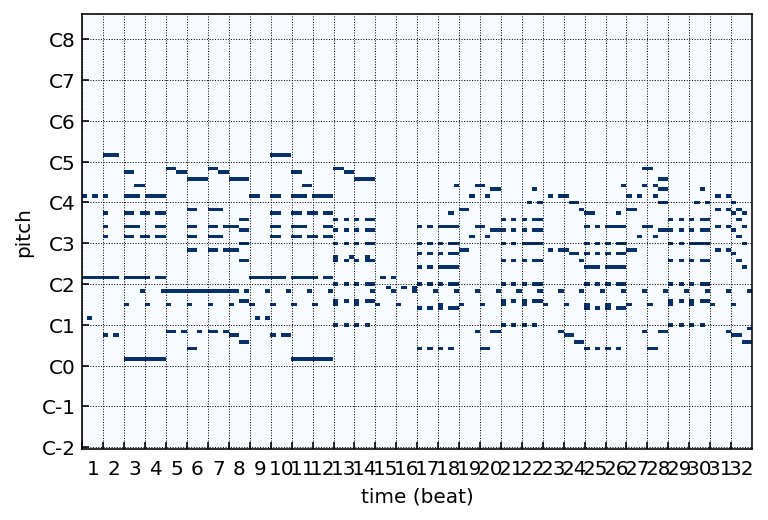

In [8]:
# Visualize a random piano roll from the dataset 
random_pianoroll = dataset_samples[randrange(len(dataset_samples))]
plot_pianoroll(pianoroll = random_pianoroll,
               beat_resolution = 4)

## Augmenting data during training
In computer vision, data augmentation is traditionally used to increase the number of training samples and make the training data more robust. In the AR-CNN model, data augmentation is a critical component of training. We use data augmentation to generate piano rolls that teach the model to add and remove notes to generate compositions.

To augment the data during training, the model uses *input-target piano roll* pairs.

The data generator, a built in function of our model, creates the modified *input piano rolls* by adding and removing notes from the original *target piano roll*. With this approach, the model learns where *edit events* are needed during training in order to recreate the *target piano roll*. An *edit event* is simply an opportunity for the model to add or remove a note. The input piano rolls used during training represent an input melody that you might provide (which might have missing or off-tune notes).

### Adding or removing notes during training
The data generator creates the input-target piano roll pairs by randomly adding and removing notes from the target piano rolls creating new input piano rolls. During each [epoch](https://docs.aws.amazon.com/deepcomposer/latest/devguide/deepcomposer-basic-concepts.html#term-epoch) or training iteration, the data generator adds or removes different notes from the target piano rolls to create new randomly generated input piano rolls. You can control how many input piano rolls are generated per target piano roll by changing the value for the `samples_per_ground_truth_data_item` variable in the `constants.py` file.

### Removing random notes from a target piano roll to create input piano rolls
To create the input piano rolls, the data generator randomly removes notes from the target piano roll. During training, the model tries to learn that it needs to *add* these notes back into the input piano rolls.   

The model removes a percentage of notes by sampling from a uniform distribution between *a lower and an upper bound*: 

- The default lower bound, `sampling_lower_bound_remove`, is set to 0%. We choose a lower bound of 0% so the model can detect an input piano roll that is identical to a target piano roll.
    
- The default upper bound, `sampling_upper_bound_remove`, is set to 100%. Choosing an upper bound of 100% allows the model to learn how to generate music from scratch when it encounters input piano rolls from which all of the notes have been removed.

>For more information about this process, see the [AR-CNN deeper diver learning capsule](https://console.aws.amazon.com/deepcomposer/home?region=us-east-1#learningCapsules/deeperDiveIntoARCNN).

![SegmentLocal](images/removenotes.gif "segment")

### Adding random notes to the target piano roll to create input piano rolls 

To create the input piano roll, the data generator also randomly adds notes to the target piano roll. The model learns that it needs to remove these notes from the input piano roll to recreate the target piano roll.

The model add a percentage of notes by sampling from a uniform distribution between *a lower and an upper bound*: 

- The default lower bound, `sampling_lower_bound_add`, is set to 0%. This represents an input piano roll that is no different from the target piano roll.
- The default upper bound, `sampling_upper_bound_add`, is set to 1.5%, based on experimentation. This might seem small, but because the percentage is based on the total number of empty pixels (which are usually far greater than the number of notes), the upper bound ends up being sufficiently large. 
    
>To learn more about this process, see the [A deep dive into training an AR-CNN model](https://console.aws.amazon.com/deepcomposer/home?region=us-east-1#learningCapsules/deeperDiveIntoARCNN).

![SegmentLocal](images/addnotes.gif "segment")

### Sampling from a uniform distribution
When randomly adding or removing notes, the model samples from a uniform distribution from a potentially different    input piano roll. By sampling from a uniform distribution, the model learns how to fill in or remove different percentages of notes. This helps the model learn how to recreate the target piano roll from the input piano roll no matter what the current state of the input piano roll is. This is useful during the iterative inference process which we describe in more detail in the Inference section

If you want to change the percentages of notes added or removed, edit and run the following cell.

In [9]:
sampling_lower_bound_remove = 0 
sampling_upper_bound_remove = 100
sampling_lower_bound_add = 1
sampling_upper_bound_add = 1.5

## Calculating the loss function

During data augmentation, the model both adds and removes notes from the *target piano roll*. We want the model to correctly pick the next *edit event*. An edit event is simply an opportunity for the model to add or remove a note from the *input piano roll*. These edit events occur when the model should update the distribution in the *input piano roll* to sound more like the distribution of the *target piano roll*.

>**NOTE**: The model can pick any of the notes that were added or removed during data augmentation.

The notes that were added or removed during data augmentation represent the *symetric difference* between the input piano roll and the target piano roll. For example, imagine your have two bowls of candy. In bowl one, you have three blue candies and one red candy. In bowl two, you have only three blue candies. In this example, the symetric difference is the single red candy. In our model, notes that have been added or removed are "red candies." 

This difference in distributions between the distribution representing the *input piano roll* and the uniform distribution can be calculated as the *Kullback–Leibler divergence*. Our loss function is the difference between the model’s output and the uniform distribution of all of the pixel (note) probabilities in the symmetric difference.

In [10]:
# Customized loss function
class Loss():
    @staticmethod 
    def built_in_softmax_kl_loss(target, output):
        '''
        Custom Loss Function
        :param target: ground truth values
        :param output: predicted values
        :return kullback_leibler_divergence loss
        '''
        target = K.flatten(target)
        output = K.flatten(output)
        target = target / K.sum(target)
        output = K.softmax(output)
        return keras.losses.kullback_leibler_divergence(target, output)

## Model architecture

Our model architecture is adapted from the *U-Net architecture* pictured below. This architecture is a popular CNN that is used for computer vision. It consists of three major components:

- An *encoder network* that takes an input piano roll as input and encodes it in a lower-dimensional *latent space*
- A *decoder network* that decodes that smaller *latent space* back out to the merged piano roll input
- A *single-track piano roll input*, which is a single-melody track of size (128, 128, 1) => (TimeStep, NumPitches, NumTracks) that is provided as the input to the model.

>**NOTE**: If you're using the Bach dataset, this input is a merged piano roll track as previously discussed. However, if you're training the model using samples that are all only a single track, the input really is a single-track piano roll input.

<img src="images/unet.png" alt="Model architecture" width="800">

### Creating the model architecture

The code for the U-Net architecture that we have developed for this AR-CNN is in `model.py`. For a higher-level view of the layers used in this neural network, see the output of the `model = MusicModel.build_model()` code cell below.

## Training

To train the model, we split the dataset into training and validation sets. We hold out 10% of the training data for the validation set. You can change this parameter by changing the `training_validation_split` variable in `constants.py`. 

As stated previously, the *input-target piano roll* pairs are generated during training. During each training epoch, different notes are added to and removed from the target piano roll to create different input piano rolls.

In [11]:
dataset_size = len(dataset_samples)
dataset_split = math.floor(dataset_size * Constants.training_validation_split) 

training_samples = dataset_samples[0:dataset_split]
print("training samples length: {}".format(len(training_samples)))
validation_samples = dataset_samples[dataset_split + 1:dataset_size]
print("validation samples length: {}".format(len(validation_samples)))

training samples length: 64
validation samples length: 7


### Specifying training hyperparameters 

The AR-CNN model's hyperparameters are defined in the following cell. If you're unfamiliar with the structure of CNNs, see the convolutional neural networks topic in [Dive into Deep Learning](https://d2l.ai/chapter_convolutional-neural-networks/index.html). 

You might consider changing the dropout values for the encoder and decoder layers: `dropout_rate_encoder` and `dropout_rate_decoder`, respectively. When training a neural network, dropout is an important tool for addressing the [the bias-variance trade off](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/statistics.html#the-bias-variance-trade-off).

>**NOTE** 
>If you want to test that your model is training on your custom dataset, you can decrease the number of `epochs` down to **1** in the cell below.

In [12]:
# Piano Roll Input Dimensions
input_dim = (Constants.bars * Constants.beats_per_bar * Constants.beat_resolution, 
             Constants.number_of_pitches, 
             Constants.number_of_channels)
# Number of Filters In The Convolution
num_filters = 32
# Growth Rate Of Number Of Filters At Each Convolution
growth_factor = 2
# Number Of Encoder And Decoder Layers
num_layers = 5
# A List Of Dropout Values At Each Encoder Layer
dropout_rate_encoder = [0, 0.5, 0.5, 0.5, 0.5]
# A List Of Dropout Values At Each Decoder Layer
dropout_rate_decoder = [0.5, 0.5, 0.5, 0.5, 0]
# A List Of Flags To Ensure If batch_normalization Should be performed At Each Encoder
batch_norm_encoder = [True, True, True, True, False]
# A List Of Flags To Ensure If batch_normalization Should be performed At Each Decoder
batch_norm_decoder = [True, True, True, True, False]
# Path to Pretrained Model If You Want To Initialize Weights Of The Network With The Pretrained Model
pre_trained = False
# Learning Rate Of The Model
learning_rate = 0.001
# Optimizer To Use While Training The Model
optimizer_enum = OptimizerType.ADAM
# Batch Size
batch_size = 32
# Number Of Epochs
epochs = 50

In [13]:
# The Number of Batch Iterations Before A Training Epoch Is Considered Finished
steps_per_epoch = int(
    len(training_samples) * Constants.samples_per_ground_truth_data_item / int(batch_size))

print("The Total Number Of Steps Per Epoch Are: "+ str(steps_per_epoch))

# Total Number Of Time Steps
n_timesteps = Constants.bars * Constants.beat_resolution * Constants.beats_per_bar

The Total Number Of Steps Per Epoch Are: 16


### Creating the data generators that perform data augmentation

To create the *input piano rolls* during training, we need data generators for both the training and validation samples. For our purposes, we use a custom data generator to perform data augmentation.

In [14]:
## Training Data Generator
training_data_generator = PianoRollGenerator(sample_list=training_samples,
                                             sampling_lower_bound_remove = sampling_lower_bound_remove,
                                             sampling_upper_bound_remove = sampling_upper_bound_remove,
                                             sampling_lower_bound_add = sampling_lower_bound_add,
                                             sampling_upper_bound_add = sampling_upper_bound_add,
                                             batch_size = batch_size,
                                             bars = Constants.bars,
                                             samples_per_data_item = Constants.samples_per_ground_truth_data_item,
                                             beat_resolution = Constants.beat_resolution,
                                             beats_per_bar = Constants.beats_per_bar,
                                             number_of_pitches = Constants.number_of_pitches,
                                             number_of_channels = Constants.number_of_channels)

In [15]:
# Validation Data Generator
validation_data_generator = PianoRollGenerator(sample_list = validation_samples,
                                               sampling_lower_bound_remove = sampling_lower_bound_remove,
                                               sampling_upper_bound_remove = sampling_upper_bound_remove,
                                               sampling_lower_bound_add = sampling_lower_bound_add,
                                               sampling_upper_bound_add = sampling_upper_bound_add,
                                               batch_size = batch_size, 
                                               bars = Constants.bars,
                                               samples_per_data_item = Constants.samples_per_ground_truth_data_item,
                                               beat_resolution = Constants.beat_resolution,
                                               beats_per_bar = Constants.beats_per_bar, 
                                               number_of_pitches = Constants.number_of_pitches,
                                               number_of_channels = Constants.number_of_channels)

### Creating callbacks for the model

Callbacks are used to get a view of the internal states and statistics of the model during training. This can include  saving the model as in a checkpoint file after each successful epoch, monitoring the change in loss from the training and validation sets, generating plots, and adjusting the learning rates over time.

In our model we use two callbacks to:
 
1. Create *training vs validation* loss plots during training.
   These graphs plot the loss after each epoch of the training and validation sets is complete. 
   - The loss values can vary widely based on the parameters that you have chosen and the dataset that you use. 

2. Save model checkpoints based on the *best validation loss*. We save the best model checkpoint so that it can be used for inference.

In [16]:
# Callback For Loss Plots 
plot_losses = GenerateTrainingPlots()
## Checkpoint Path
checkpoint_filepath =  'checkpoints/-best-model-epoch:{epoch:04d}.hdf5'

# Callback For Saving Model Checkpoints 
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Create A List Of Callbacks
callbacks_list = [plot_losses, model_checkpoint_callback]

In [17]:
# Create A Model Instance
MusicModel = ArCnnModel(input_dim = input_dim,
                        num_filters = num_filters,
                        growth_factor = growth_factor,
                        num_layers = num_layers,
                        dropout_rate_encoder = dropout_rate_encoder,
                        dropout_rate_decoder = dropout_rate_decoder,
                        batch_norm_encoder = batch_norm_encoder,
                        batch_norm_decoder = batch_norm_decoder,
                        pre_trained = pre_trained,
                        learning_rate = learning_rate,
                        optimizer_enum = optimizer_enum)

In [18]:
model = MusicModel.build_model()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0

## Starting training 

In the following cell, you start training your model.

>**NOTE**: Training times can vary greatly based on the parameters that you have chosen and the notebook instance type that you chose when launching this notebook. 

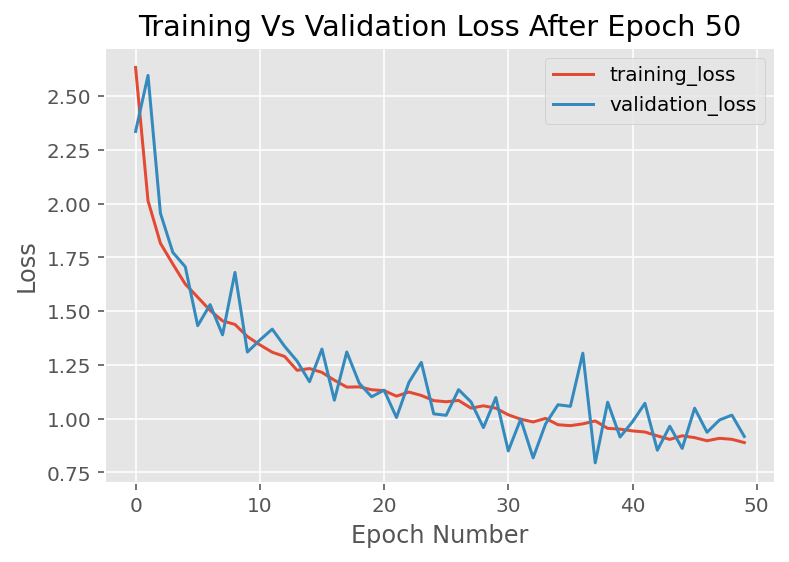

In [19]:
# Start Training
history = model.fit_generator(training_data_generator,
                              validation_data = validation_data_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs = epochs,
                              callbacks = callbacks_list)

## Performing inference 

Congratulations! You have now trained your very own AR-CNN model to generate music. Now you can see how well your model will perform with an input melody. 


### How to change the *inference parameters* when you perform inference 

The model performs inference by sampling from its predicted probability distribution across the entire piano roll. 

Inference is an iterative process. After adding or removing a note from the input, the model feeds this new input back into itself. The model has been trained to both remove and add notes, so it can improve the input melody and correct mistakes that it may have made in earlier iterations.

You also can change the *inference parameters* to observe differences in the quality of the music generated: 

- Sampling iterations (`samplingIterations`): The number of iterations performed during inference. A higher number of sampling iterations gives the model more time to improve the input melody.

- Maximum notes to remove (`maxPercentageOfInitialNotesRemoved`): The maximum percentage of notes that can be removed during inference. Setting this value to 0% prevents the model from removing notes from your input melody.

- Maximum notes to add (`maxNotesAdded`): The maximum percentage of notes that can be added during inference. Setting this value to 0% means no notes will be added to your input melody

>**NOTE:** If you restrict your model's ability to add and remove notes, you risk creating poor compositions. 

- Creativity, `temperature`: To create the output probability distribution, the final layer uses a softmax activation. You can change the temperature for the softmax to produce different levels of creativity in the outputs generated by the model.


#### To change the inference parameters:

1. Open the `inference_parameters.json` file. 
2. Update the variables.
3. Save and close the `inference_parameters.json` file. 
4. Run the following cell.

In [20]:
# Load The Inference-Related Parameters
with open('inference_parameters.json') as json_file:
    inference_params = json.load(json_file)

### Loading a saved checkpoint file

To use your trained model, you will need to update the `checkpoint_var` variable in the cell below. To see the checkpoint files that you have created, uncomment and then run the following cell.

In [ ]:
# !ls -ltr checkpoints/

In the next code cell, replace the string in variable `checkpoint_var` with the filename, `checkpoints/foo-bar.hdf5` 

In [51]:
# Create An Inference Object
inference_obj = Inference()
# Load The Checkpoint
checkpoint_var = 'checkpoints/-best-model-epoch:0038.hdf5'
inference_obj.load_model(checkpoint_var) 

#### To choose a new input melody

1. In a different tab, switch back to the Jupyter console
2. Open the `sample_inputs` directory. It contains six sample melodies. 
3. Note the name of the file that you want to use, for example, 'new_world.midi'. 
4. In the following cell, replace **'sample_inputs/ode_to_joy.midi'** with the name of the file and run the cell below

In [64]:
# Generate The Composition
input_melody = 'sample_inputs/input(11).midi'  
inference_obj.generate_composition(input_melody, inference_params)

#### To listen to your composition

1. Run the following cell. It lists our compositions. 
2. Note the filename of the composition that you want to listen to, for example, "output_2.mid".

In [67]:
#!ls -ltr outputs/
#!zip -r checkpoints.zip checkpoints
!zip -r outputs.zip outputs

  adding: outputs/ (stored 0%)
  adding: outputs/output_1.mid (deflated 45%)
  adding: outputs/output_0.mid (deflated 46%)
  adding: outputs/output_5.mid (deflated 47%)
  adding: outputs/output_2.mid (deflated 44%)
  adding: outputs/output_14.mid (deflated 50%)
  adding: outputs/output_11.mid (deflated 46%)
  adding: outputs/output_8.mid (deflated 50%)
  adding: outputs/output_9.mid (deflated 42%)
  adding: outputs/output_10.mid (deflated 48%)
  adding: outputs/output_13.mid (deflated 47%)
  adding: outputs/output_4.mid (deflated 45%)
  adding: outputs/output_6.mid (deflated 47%)
  adding: outputs/output_7.mid (deflated 48%)
  adding: outputs/output_12.mid (deflated 43%)
  adding: outputs/output_3.mid (deflated 49%)


3. In the following cell, replace **'outputs/output_0.mid'** with the name of the file and run the cell below

In [65]:
output_melody = 'outputs/output_14.mid'
play_midi(output_melody)

>**NOTE**: Compositions are automatically saved. To download a composition that you have created, open the `outputs` directory. Choose your composition, then choose **Download**. ![downloading-your-compositions](images/download-composition.png)

## Evaluating your results

Now that you've generated a composition, let's find out how you did by running the code cells below. The code cells below provide you with some model metrics and a visualization of the piano rolls created.    

We'll analyze the composition using the following metrics: 

- *Empty bar rate:* The ratio of empty bars to the total number of bars. 
- *Pitch histogram distance:* The distribution and position of pitches.
- *In scale ratio:*  The ratio of the number of notes, in the C major key, to the total number of notes. 


### Visualizing the results
After computing the metrics, let's also visualize the *input piano roll* and compare it with the generated output piano roll to see which notes have been changed.

In [56]:
# Input Midi Metrics:
print("The input midi metrics are:")
get_music_metrics(input_melody, beat_resolution=4)

print("\n")
# Generated Output Midi Metrics:
print("The generated output midi metrics are:")
get_music_metrics(output_melody, beat_resolution=4)

The input midi metrics are:
+----------------------+---------------+-----------------+----------------+
| n_pitch_classes_used | in_scale_rate | polyphonic_rate | n_pitches_used |
+======================+===============+=================+================+
| 4                    | 0.469         | 15              | 25.164         |
+----------------------+---------------+-----------------+----------------+


The generated output midi metrics are:
+----------------------+---------------+-----------------+----------------+
| n_pitch_classes_used | in_scale_rate | polyphonic_rate | n_pitches_used |
+======================+===============+=================+================+
| 6                    | 0.341         | 16              | 40.509         |
+----------------------+---------------+-----------------+----------------+


In [57]:
# Convert The Input and Generated Midi To Tensors (a matrix)
input_pianoroll = process_midi(input_melody, beat_resolution=4)
output_pianoroll = process_midi(output_melody, beat_resolution=4)

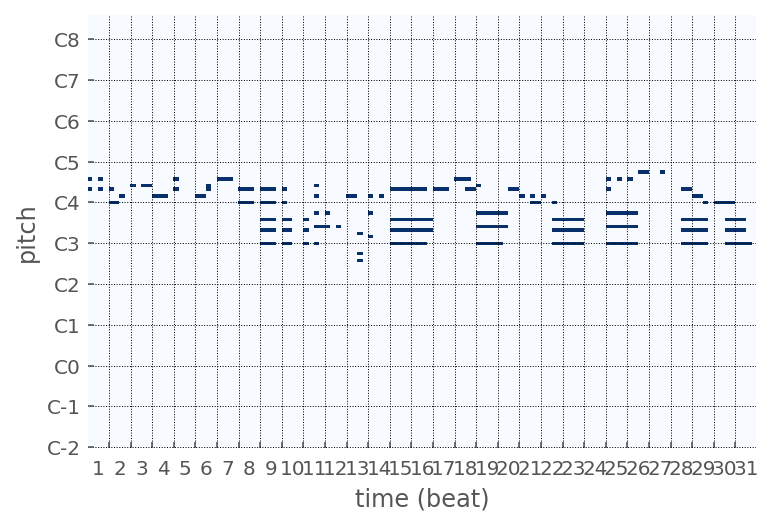

In [58]:
# Plot Input Piano Roll
plot_pianoroll(input_pianoroll, beat_resolution=4)

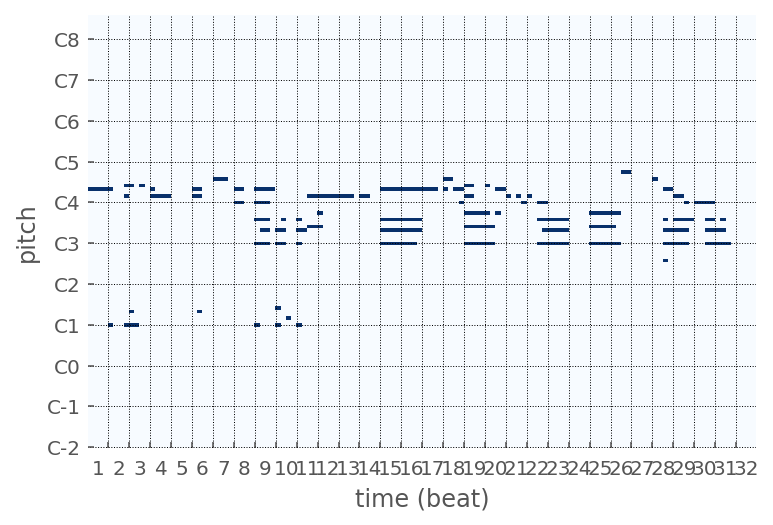

In [59]:
# Plot Output Piano Roll
plot_pianoroll(output_pianoroll, beat_resolution=4)

## Submitting to the *Spin the Model* Chartbusters challnege

To submit your composition(s) and model to the *Spin the model* chartbusters challenge you will first need to create a public repository on [GitHub](https://github.com/). Then download your notebook, checkpoint files, and compositions from SageMaker, and upload them to your public repository. Use the link from your public repository to make your submission to the Chartbusters challenge! 

## Cleaning up 

After completing this notebook, make sure that you stop your Amazon SageMaker notebook instance so that you don't incur unexpected costs. 

#### To stop an Amazon SageMaker notebook instance 

1. Open the [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/dashboard).

2. In the navigation pane, choose **Notebook instances**.

3. Choose the notebook instance that you want to stop. 

4. From the **Actions** menu, choose **Stop**.

>**NOTE**: When your notebook instance stops, its status changes from **In service** to **Stopped**. 

# More info

For more open-source implementations of generative models for music, see the following:

- [MuseNet](https://openai.com/blog/musenet/): Uses GPT2, a large-scale Transformer model, to predict the next token in a sequence
- [Jukebox](https://openai.com/blog/jukebox/): Uses various neural nets to generate music, including rudimentary singing, as raw audio in a variety of genres and artist styles
- [Music Transformer](https://github.com/tensorflow/magenta/tree/master/magenta/models/score2perf): Uses transformers to generate music

## References

<a id='references'></a>
1. [MuseGAN: Multi-track Sequential Generative Adversarial Networks for Symbolic Music Generation and Accompaniment.](https://arxiv.org/abs/1709.06298)
2. [MidiNet: A Convolutional Generative Adversarial Network for Symbolic-domain Music Generation.](https://arxiv.org/abs/1703.10847)
3. [A Hierarchical Recurrent Neural Network for Symbolic Melody Generation.](https://pubmed.ncbi.nlm.nih.gov/31796422/)
4. [Counterpoint by Convolution](https://arxiv.org/abs/1903.07227)
5. [MusicTransformer:Generating Music With Long-Term Structure](https://arxiv.org/abs/1809.04281)
6. [Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)
7. [Neural Autoregressive Distribution Estimation](https://arxiv.org/abs/1605.02226)
